<a href="https://colab.research.google.com/github/Maosef/498L_Final_Project/blob/master/dcgan_large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


DCGAN Tutorial
==============

Based on the code by `Nathan Inkawhich <https://github.com/inkawhich>`__




In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [0]:
# # GPU details

# print(torch.cuda.is_available())
# print(torch.cuda.current_device())
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))

## Hyperparameters

In [0]:
# Root directory for dataset
# dataroot = "/content/drive/My Drive/Colab Notebooks/celeba"
# dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator and D
ngf = 64
ndf = 64

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# model name
model_name = "lsun_classroom"

## Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks
 bedroom_train_lmdb					      dcgan.ipynb
 bedroom_val_lmdb.zip					      dcgan_large.ipynb
 Bonus.ipynb						     'GAN models'
 _cache_contentdriveMyDriveColabNotebooksclassroomtrainlmdb   lsun
 cat.zip						      LSUN
 CelebA							      MNIST
 CIFAR							      QARP_Model.ipynb
 classroom_train_lmdb					      STL10
 classroom_train_lmdb.zip				      tb_log
'Copy of Qarp_model (1).ipynb'				      Untitled0.ipynb
'Copy of QARP Model - Portfolio Calculations (2 24 2019)'


## Download and Extract Data

In [0]:
# !python lsun/download.py -c bedroom # this is huge
# !python lsun/download.py -c classroom 
# !unzip classroom_train_lmdb.zip

# !python lsun/data.py view bedroom_train_lmdb.zip

# !unzip bedroom_train_lmdb.zip
# !zip -FF bedroom_train_lmdb.zip --out bedroom_train_lmdb_fix.zip



In [0]:
# import lmdb
# import time

# dataroot = "/content/drive/My Drive/Colab Notebooks/classroom_train_lmdb"
# # dataroot = "/content/drive/My Drive/Colab Notebooks/bedroom_val_lmdb"

# # env = lmdb.open(dataroot)
# env = lmdb.open(dataroot, map_size=1099511627776,
#                     max_readers=100, readonly=True)
# with env.begin(write=False) as txn:
#   print('cursor...')
#   time.sleep(1)
#   for key, _ in txn.cursor():
#     print(str(key))
#     time.sleep(1)
#     # self.keys = [key for key, _ in txn.cursor()]

In [0]:

# # !unzip '/content/drive/My Drive/Colab Notebooks/img_align_celeba.zip' -d '/content/drive/My Drive/Colab Notebooks/celeba'


# from PIL import Image
# import os
# import os.path
# import io
# import string
# from collections.abc import Iterable
# import pickle
# from torchvision.datasets.utils import verify_str_arg, iterable_to_str

# from torchvision.datasets.lsun import LSUNClass as LSUNClass_old

# # dataroot = "/content/drive/My Drive/Colab Notebooks/LSUN"

# LSUN = dset.LSUN

# class LSUNClass(LSUNClass_old):
#   def __init__(self, root, transform=None, target_transform=None):
#         import lmdb
#         print('init...')
#         time.sleep(1)

#         super(LSUNClass_old, self).__init__(root, transform=transform,
#                                         target_transform=target_transform)

#         self.env = lmdb.open(root,  map_size=1000, max_readers=1, readonly=True, lock=False,
#                              readahead=False, meminit=False)
#         print('reading...')
#         time.sleep(1)

#         with self.env.begin(write=False) as txn:
#             self.length = txn.stat()['entries']
#             print(self.length)
#             time.sleep(1)

#         print('loading...')
#         time.sleep(1)
#         cache_file = '_cache_' + ''.join(c for c in root if c in string.ascii_letters)
#         if os.path.isfile(cache_file):
#             self.keys = pickle.load(open(cache_file, "rb"))
#         else:
#             with self.env.begin(write=False) as txn:
#               for key, _ in txn.cursor():
#                 print(str(key))
#                 time.sleep(1)
#                 self.keys = [key for key, _ in txn.cursor()]
#             pickle.dump(self.keys, open(cache_file, "wb"))

# class LSUN_obj(LSUN): #overwrite LSUN dataset

#   def __init__(self, root, classes='train', transform=None, target_transform=None):
#         super(LSUN, self).__init__(root, transform=transform,
#                                    target_transform=target_transform)
#         # self.classes = self._verify_classes(classes)
#         self.classes = classes

#         # for each class, create an LSUNClassDataset
#         self.dbs = []
#         for c in self.classes:
#             self.dbs.append(LSUNClass(
#                 # root=root + '/' + c + '_lmdb',
#                 root=root + '/' + c ,
#                 transform=transform))

#         self.indices = []
#         count = 0
#         for db in self.dbs:
#             count += len(db)
#             self.indices.append(count)

#         self.length = count

#   def _verify_classes(self, classes):
#       # categories = ['cat','bedroom', 'bridge', 'church_outdoor', 'classroom',
#       #               'conference_room', 'dining_room', 'kitchen',
#       #               'living_room', 'restaurant', 'tower']
#       # dset_opts = ['train', 'val', 'test']

#       # try:
#       #     verify_str_arg(classes, "classes", dset_opts)
#       #     if classes == 'test':
#       #         classes = [classes]
#       #     else:
#       #         classes = [c + '_' + classes for c in categories]
#       # except ValueError:
#       #     if not isinstance(classes, Iterable):
#       #         msg = ("Expected type str or Iterable for argument classes, "
#       #                 "but got type {}.")
#       #         raise ValueError(msg.format(type(classes)))

#       #     classes = list(classes)
#       #     msg_fmtstr = ("Expected type str for elements in argument classes, "
#       #                   "but got type {}.")
#       #     for c in classes:
#       #         print(c)
#       #         verify_str_arg(c, custom_msg=msg_fmtstr.format(type(c)))
#       #         c_short = c.split('_')
#       #         category, dset_opt = '_'.join(c_short[:-1]), c_short[-1]

#       #         msg_fmtstr = "Unknown value '{}' for {}. Valid values are {{{}}}."
#       #         msg = msg_fmtstr.format(category, "LSUN class",
#       #                                 iterable_to_str(categories))
#       #         verify_str_arg(category, valid_values=categories, custom_msg=msg)

#       #         msg = msg_fmtstr.format(dset_opt, "postfix", iterable_to_str(dset_opts))
#       #         verify_str_arg(dset_opt, valid_values=dset_opts, custom_msg=msg)
#       print(classes)
#       return classes


In [0]:
# import PIL

# # path = "/content/drive/My Drive/Colab Notebooks/CelebA/celeba/img_align_celeba"
# # path = "/content/drive/My Drive/Colab Notebooks/CelebA/celeba/img_align_celeba/091247.jpg"
# path = "/content/drive/My Drive/Colab Notebooks/CelebA/celeba/img_align_celeba/095352.jpg"

# # print(len(os.listdir(path)))

# X = PIL.Image.open(os.path.join(path))
# plt.imshow(X)

## Load Data

plotting...


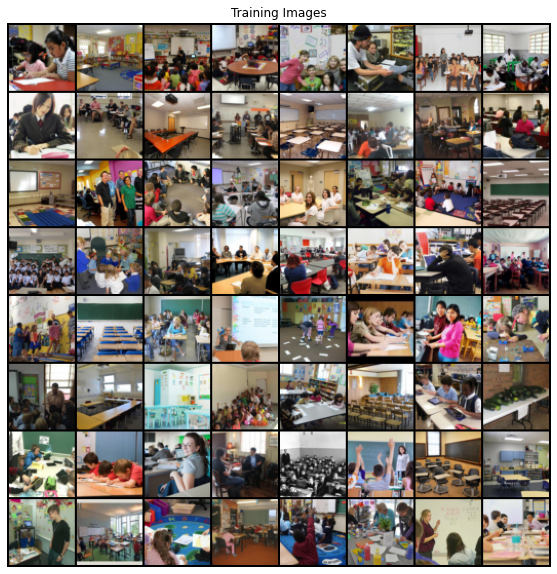

In [0]:
import time
# %%time

# We can use an image folder dataset the way we have it setup.
# Create the dataset
# dataroot = "/content/drive/My Drive/Colab Notebooks/CIFAR"
# dataroot = "/content/drive/My Drive/Colab Notebooks/STL10"
# dataroot = "/content/drive/My Drive/Colab Notebooks/LSUN"
# dataroot = "/content/drive/My Drive/Colab Notebooks/CelebA"
dataroot = "/content/drive/My Drive/Colab Notebooks"


# print('loading 1...')
# time.sleep(1)

# dataset = dset.CelebA(dataroot, split='train', transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
#                                ]), download=False)

# image_size = 256
dataset = dset.LSUN(root=dataroot, classes=['classroom_train'], transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]),)
# dataset = LSUN_obj(root=dataroot, classes=['cat'])

# dataset = dset.STL10(root=dataroot, split='train+unlabeled', download=False,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]),
#                      )


# print('loading 2...')
# time.sleep(1)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
print('plotting...')
real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
plt.figure(figsize=(10,10))

plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
print(len(dataset))

168103


In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Model Architecture

In [0]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [0]:
# # bad generator

# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
#             # nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             # nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             # nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             # nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
#         )

#     def forward(self, input):
#         return self.main(input)

In [0]:
# # bad discriminator

# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is (nc) x 64 x 64
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 32 x 32
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             # nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 16 x 16
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             # nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 8 x 8
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             # nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 4 x 4
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)

Discriminator Code



In [0]:
# good discriminator

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and discriminator, apply the ``weights_init``
function, and print the model’s structure.




In [0]:
# # load_network_path = 'Saved models/best_detector.pth'
# # load_network_path = 'best_detector.pth'
# load_network_path = None
# pretrained = True

# # use to load a previously trained network
# if load_network_path is not None:
#     print('Loading saved network from {}'.format(load_network_path))
#     net = resnet50().to(device)
#     net.load_state_dict(torch.load(load_network_path))
# else:
#     print('Load pre-trained model')
#     net = resnet50(pretrained=pretrained).to(device)

In [0]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)



# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerD = optim.Adam(netD.parameters())
# optimizerG = optim.Adam(netG.parameters())

## Tensorboard

In [0]:
# tensorboard
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard
%tensorboard --logdir=tb_log/DCGAN_lsun_classroom # make sure to cd into the right place before


Reusing TensorBoard on port 6006 (pid 1698), started 1:17:12 ago. (Use '!kill 1698' to kill it.)

<IPython.core.display.Javascript object>

## Training

Starting Training Loop...


/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/30][0/1314]	Loss_D: 1.7047	Loss_G: 6.6442	D(x): 0.6453	D(G(z)): 0.6281 / 0.0021


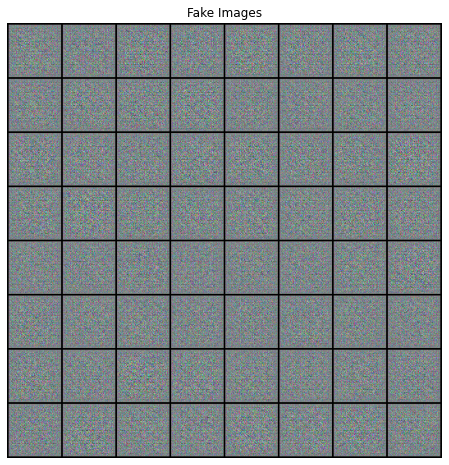

[0/30][50/1314]	Loss_D: 0.1479	Loss_G: 4.2866	D(x): 0.9244	D(G(z)): 0.0462 / 0.0238
[0/30][100/1314]	Loss_D: 0.4200	Loss_G: 3.6310	D(x): 0.8869	D(G(z)): 0.2352 / 0.0424
[0/30][150/1314]	Loss_D: 0.4310	Loss_G: 3.5933	D(x): 0.8904	D(G(z)): 0.2213 / 0.0511
[0/30][200/1314]	Loss_D: 0.4798	Loss_G: 6.1210	D(x): 0.7427	D(G(z)): 0.0340 / 0.0040
[0/30][250/1314]	Loss_D: 1.3934	Loss_G: 3.9702	D(x): 0.6486	D(G(z)): 0.4272 / 0.0402
[0/30][300/1314]	Loss_D: 0.8116	Loss_G: 3.6642	D(x): 0.5784	D(G(z)): 0.0805 / 0.0372
[0/30][350/1314]	Loss_D: 1.1320	Loss_G: 8.6597	D(x): 0.8504	D(G(z)): 0.5214 / 0.0003
[0/30][400/1314]	Loss_D: 0.4682	Loss_G: 3.5717	D(x): 0.8217	D(G(z)): 0.1950 / 0.0382
[0/30][450/1314]	Loss_D: 2.9658	Loss_G: 4.4922	D(x): 0.1022	D(G(z)): 0.0017 / 0.0295
[0/30][500/1314]	Loss_D: 0.3884	Loss_G: 5.5383	D(x): 0.8154	D(G(z)): 0.1176 / 0.0067


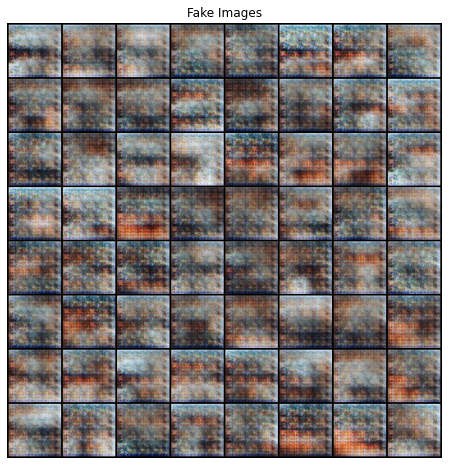

[0/30][550/1314]	Loss_D: 0.5515	Loss_G: 3.5826	D(x): 0.7158	D(G(z)): 0.1128 / 0.0407
[0/30][600/1314]	Loss_D: 0.9345	Loss_G: 10.4543	D(x): 0.9191	D(G(z)): 0.4673 / 0.0002
[0/30][650/1314]	Loss_D: 0.5347	Loss_G: 4.2178	D(x): 0.6776	D(G(z)): 0.0315 / 0.0250
[0/30][700/1314]	Loss_D: 0.5712	Loss_G: 3.8042	D(x): 0.7120	D(G(z)): 0.1427 / 0.0318
[0/30][750/1314]	Loss_D: 0.3368	Loss_G: 4.5763	D(x): 0.7860	D(G(z)): 0.0437 / 0.0158
[0/30][800/1314]	Loss_D: 0.5619	Loss_G: 5.9158	D(x): 0.8665	D(G(z)): 0.2911 / 0.0042
[0/30][850/1314]	Loss_D: 0.2716	Loss_G: 5.3484	D(x): 0.8162	D(G(z)): 0.0369 / 0.0087
[0/30][900/1314]	Loss_D: 1.2047	Loss_G: 6.2351	D(x): 0.4267	D(G(z)): 0.0014 / 0.0061
[0/30][950/1314]	Loss_D: 0.4489	Loss_G: 4.1525	D(x): 0.7547	D(G(z)): 0.0722 / 0.0322
[0/30][1000/1314]	Loss_D: 0.5217	Loss_G: 4.0405	D(x): 0.7634	D(G(z)): 0.1464 / 0.0285


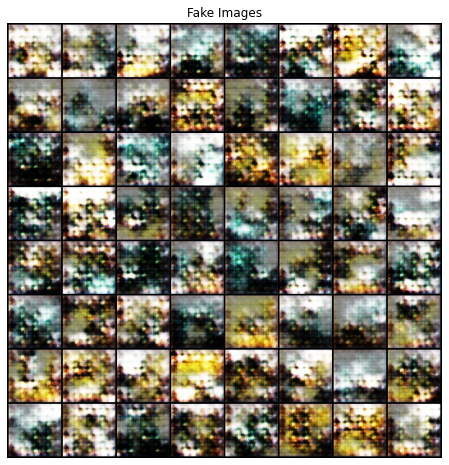

[0/30][1050/1314]	Loss_D: 0.6465	Loss_G: 3.4612	D(x): 0.6661	D(G(z)): 0.0906 / 0.0501
[0/30][1100/1314]	Loss_D: 0.3706	Loss_G: 4.0149	D(x): 0.8833	D(G(z)): 0.1854 / 0.0301
[0/30][1150/1314]	Loss_D: 0.9506	Loss_G: 0.4133	D(x): 0.5182	D(G(z)): 0.0096 / 0.7487
[0/30][1200/1314]	Loss_D: 0.4253	Loss_G: 4.4209	D(x): 0.7766	D(G(z)): 0.0968 / 0.0248
[0/30][1250/1314]	Loss_D: 0.2518	Loss_G: 4.2277	D(x): 0.8784	D(G(z)): 0.0883 / 0.0231
[0/30][1300/1314]	Loss_D: 0.4081	Loss_G: 4.3505	D(x): 0.8062	D(G(z)): 0.1132 / 0.0264
time (s):  8743.867121458054
[1/30][0/1314]	Loss_D: 0.5079	Loss_G: 6.2862	D(x): 0.9210	D(G(z)): 0.3019 / 0.0035
[1/30][50/1314]	Loss_D: 0.3574	Loss_G: 5.3604	D(x): 0.8647	D(G(z)): 0.1545 / 0.0071
[1/30][100/1314]	Loss_D: 0.4120	Loss_G: 4.4498	D(x): 0.7634	D(G(z)): 0.0562 / 0.0229
[1/30][150/1314]	Loss_D: 0.2965	Loss_G: 1.5761	D(x): 0.8657	D(G(z)): 0.1019 / 0.3246


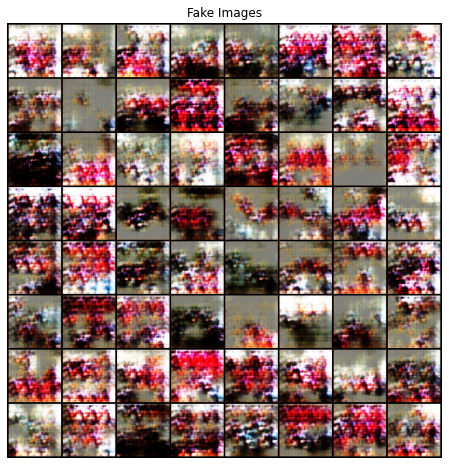

[1/30][200/1314]	Loss_D: 0.1285	Loss_G: 4.6655	D(x): 0.9272	D(G(z)): 0.0422 / 0.0151
[1/30][250/1314]	Loss_D: 2.3837	Loss_G: 10.8461	D(x): 0.9948	D(G(z)): 0.7961 / 0.0002
[1/30][300/1314]	Loss_D: 0.5746	Loss_G: 3.6841	D(x): 0.6861	D(G(z)): 0.0722 / 0.0545
[1/30][350/1314]	Loss_D: 0.2996	Loss_G: 5.1326	D(x): 0.9098	D(G(z)): 0.1682 / 0.0087
[1/30][400/1314]	Loss_D: 0.7480	Loss_G: 7.8996	D(x): 0.5901	D(G(z)): 0.0032 / 0.0025
[1/30][450/1314]	Loss_D: 0.5306	Loss_G: 4.3516	D(x): 0.7807	D(G(z)): 0.1702 / 0.0239
[1/30][500/1314]	Loss_D: 0.3987	Loss_G: 3.6934	D(x): 0.8654	D(G(z)): 0.1886 / 0.0410
[1/30][550/1314]	Loss_D: 0.3897	Loss_G: 4.8403	D(x): 0.7610	D(G(z)): 0.0318 / 0.0208
[1/30][600/1314]	Loss_D: 0.4001	Loss_G: 3.7056	D(x): 0.8201	D(G(z)): 0.1258 / 0.0400
[1/30][650/1314]	Loss_D: 1.2751	Loss_G: 3.6229	D(x): 0.4209	D(G(z)): 0.0031 / 0.0558


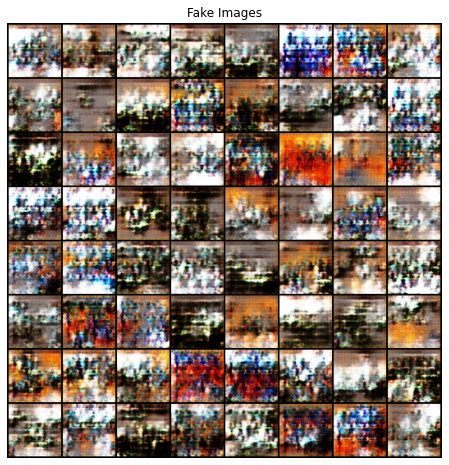

[1/30][700/1314]	Loss_D: 0.2869	Loss_G: 3.4154	D(x): 0.8577	D(G(z)): 0.0955 / 0.0501
[1/30][750/1314]	Loss_D: 0.2470	Loss_G: 4.4131	D(x): 0.8308	D(G(z)): 0.0321 / 0.0215
[1/30][800/1314]	Loss_D: 0.3381	Loss_G: 4.3830	D(x): 0.7995	D(G(z)): 0.0472 / 0.0254
[1/30][850/1314]	Loss_D: 0.5308	Loss_G: 2.9956	D(x): 0.7004	D(G(z)): 0.0435 / 0.0758
[1/30][900/1314]	Loss_D: 0.3856	Loss_G: 6.2884	D(x): 0.9437	D(G(z)): 0.2528 / 0.0027
[1/30][950/1314]	Loss_D: 0.2118	Loss_G: 4.6414	D(x): 0.8640	D(G(z)): 0.0420 / 0.0156
[1/30][1000/1314]	Loss_D: 1.0602	Loss_G: 7.5994	D(x): 0.9647	D(G(z)): 0.5755 / 0.0010
[1/30][1050/1314]	Loss_D: 0.6942	Loss_G: 7.6073	D(x): 0.9160	D(G(z)): 0.3909 / 0.0010
[1/30][1100/1314]	Loss_D: 0.6245	Loss_G: 2.6639	D(x): 0.6450	D(G(z)): 0.0538 / 0.1083
[1/30][1150/1314]	Loss_D: 3.2325	Loss_G: 11.7776	D(x): 0.9975	D(G(z)): 0.9119 / 0.0000


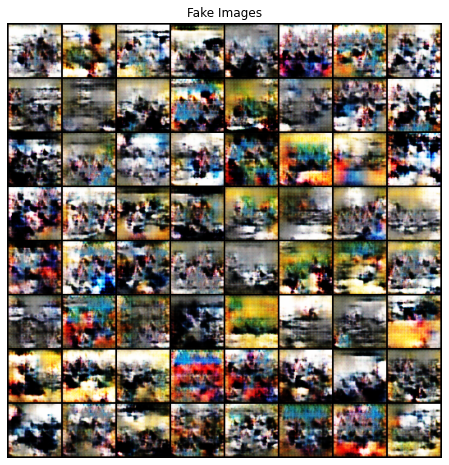

[1/30][1200/1314]	Loss_D: 0.3838	Loss_G: 3.7210	D(x): 0.8666	D(G(z)): 0.1811 / 0.0358
[1/30][1250/1314]	Loss_D: 0.3234	Loss_G: 4.5329	D(x): 0.9247	D(G(z)): 0.1910 / 0.0166
[1/30][1300/1314]	Loss_D: 0.6008	Loss_G: 2.7310	D(x): 0.6354	D(G(z)): 0.0449 / 0.1026
time (s):  8520.80095076561
[2/30][0/1314]	Loss_D: 0.5087	Loss_G: 2.5641	D(x): 0.6891	D(G(z)): 0.0592 / 0.1372
[2/30][50/1314]	Loss_D: 0.5284	Loss_G: 5.7419	D(x): 0.9324	D(G(z)): 0.3082 / 0.0060
[2/30][100/1314]	Loss_D: 0.5454	Loss_G: 3.6624	D(x): 0.7800	D(G(z)): 0.1899 / 0.0461
[2/30][150/1314]	Loss_D: 0.3669	Loss_G: 3.5117	D(x): 0.7874	D(G(z)): 0.0727 / 0.0557
[2/30][200/1314]	Loss_D: 0.3245	Loss_G: 4.4090	D(x): 0.8690	D(G(z)): 0.1401 / 0.0185
[2/30][250/1314]	Loss_D: 0.3119	Loss_G: 2.8136	D(x): 0.8654	D(G(z)): 0.1234 / 0.0983
[2/30][300/1314]	Loss_D: 0.3045	Loss_G: 3.8135	D(x): 0.8361	D(G(z)): 0.0959 / 0.0338
[2/30][350/1314]	Loss_D: 0.4390	Loss_G: 5.0265	D(x): 0.9057	D(G(z)): 0.2431 / 0.0136


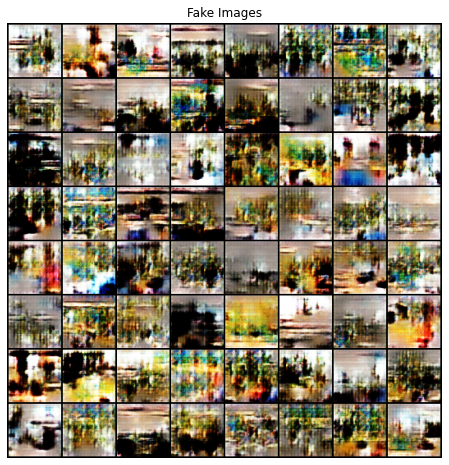

[2/30][400/1314]	Loss_D: 0.2920	Loss_G: 3.3654	D(x): 0.8544	D(G(z)): 0.0899 / 0.0545
[2/30][450/1314]	Loss_D: 0.4123	Loss_G: 5.0452	D(x): 0.8757	D(G(z)): 0.1969 / 0.0124
[2/30][500/1314]	Loss_D: 1.1107	Loss_G: 7.8805	D(x): 0.9576	D(G(z)): 0.5717 / 0.0008
[2/30][550/1314]	Loss_D: 0.3645	Loss_G: 4.1520	D(x): 0.8954	D(G(z)): 0.1805 / 0.0268
[2/30][600/1314]	Loss_D: 2.4771	Loss_G: 1.5507	D(x): 0.1614	D(G(z)): 0.0015 / 0.3244
[2/30][650/1314]	Loss_D: 0.6657	Loss_G: 6.8065	D(x): 0.9651	D(G(z)): 0.4231 / 0.0018
[2/30][700/1314]	Loss_D: 0.4925	Loss_G: 5.7352	D(x): 0.8852	D(G(z)): 0.2562 / 0.0057
[2/30][750/1314]	Loss_D: 0.9886	Loss_G: 8.8216	D(x): 0.9771	D(G(z)): 0.5248 / 0.0005
[2/30][800/1314]	Loss_D: 0.2366	Loss_G: 4.6250	D(x): 0.9112	D(G(z)): 0.1160 / 0.0160
[2/30][850/1314]	Loss_D: 0.4003	Loss_G: 4.1164	D(x): 0.8717	D(G(z)): 0.1972 / 0.0257


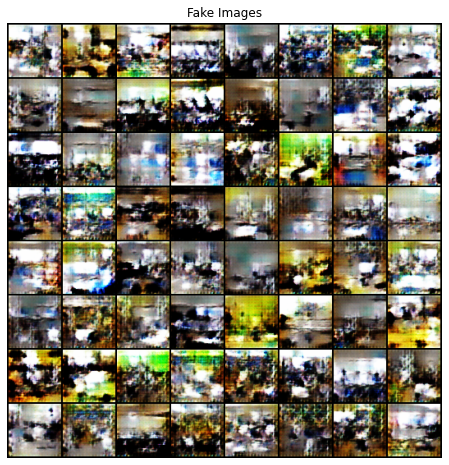

[2/30][900/1314]	Loss_D: 0.3589	Loss_G: 5.8871	D(x): 0.9380	D(G(z)): 0.2293 / 0.0042


In [0]:
%%time

import time

model_path = "/content/drive/My Drive/Colab Notebooks/GAN models/"

# load model
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

best_loss = np.inf

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

name = 'DCGAN_lsun_classroom'
summary_writer = SummaryWriter(log_dir="tb_log/{}".format(name if len(name) else None ))

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    start = time.time()
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            summary_writer.add_scalar("loss/D",errD.item(), epoch*821 + i) # add train loss to tensorboard
            summary_writer.add_scalar("loss/G",errG.item(), epoch*821 + i) # add train loss to tensorboard


        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            # Plot the fake images from the last epoch
            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title("Fake Images")
            plt.imshow(np.transpose(img_list[-1],(1,2,0)))
            plt.show()
            
        iters += 1

    print("time (s): ",time.time()-start)
    # save models
    torch.save(netD.state_dict(), model_path + name + "netD")
    torch.save(netG.state_dict(), model_path + name + "netG")


Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




In [0]:
def moving_average(a, n=50) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training (50 iter. moving average)")
# plt.plot(G_losses,label="G")
# plt.plot(D_losses,label="D")
plt.plot(moving_average(G_losses),label="G")
plt.plot(moving_average(D_losses),label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.yscale("log")

plt.legend()
plt.show()

lets take a look at some real images and fake images side by
side.

In [0]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Where to Go Next
----------------

We have reached the end of our journey, but there are several places you
could go from here. You could:

-  Train for longer to see how good the results get
-  Modify this model to take a different dataset and possibly change the
   size of the images and the model architecture
-  Check out some other cool GAN projects
   `here <https://github.com/nashory/gans-awesome-applications>`__
-  Create GANs that generate
   `music <https://deepmind.com/blog/wavenet-generative-model-raw-audio/>`__


